<a href="https://colab.research.google.com/github/thiagolages/DCC831-deep-learning-algorithms/blob/master/04_AE_CNN_with_Regularization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CNN Autoencoder with regularization term: usando the functional API

Neste notebook, vamos usar um autoencoder baseado em CNNs para os dígitos do MNIST usando uma regularização L1 para os elementos do vetor z no code. Isto é, a loss function terá dois termos. Um deles e' o MSE entre entrada e saida.
O termo adicional e' um custo L1, igual a lambda*sum(abs(z)).

Não vamos usar um vetor z de dimensão tão pequena quanto 2, como fizemos anteriormente. Vamos deixar o vetor z um pouco maior (dimensao 20). Não procurei otimizar a escolha da dimensão do vetor z, nem aqui nem nos demais notebooks.

In [1]:
from tensorflow.keras import backend as K
# importa o módulo backend da API Keras no TensorFlow.
# Esse módulo fornece uma interface para interagir diretamente com as operações
# de baixo nível do TensorFlow, permitindo maior controle sobre cálculos
# matemáticos, manipulação de tensores e outras operações personalizadas.

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Reshape, Input
from tensorflow.keras.layers import MaxPooling2D, Dropout, UpSampling2D
from tensorflow.keras.regularizers import l1 # importing the L1 regularization method from TensorFlow's Keras module.
from tensorflow.keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt

2024-12-01 22:54:54.414520: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-01 22:54:54.424335: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733104494.433939  854477 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733104494.436814  854477 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-01 22:54:54.448413: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
# Load mnist dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Scale images to the interval [0,1]
x_train = x_train.astype('float32')/255
x_test = x_test.astype('float32')/255
x_train = x_train.reshape((len(x_train), 28, 28, 1))
x_test = x_test.reshape((len(x_test), 28, 28, 1))

print(f'x_train shape = {x_train.shape}')
print(f'x_test shape = {x_test.shape}')

x_train shape = (60000, 28, 28, 1)
x_test shape = (10000, 28, 28, 1)


In [3]:
# Specifying the model

input_img = Input(shape=(28, 28, 1))

x = Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same')(input_img)
# Output Shape = (28, 28, 16)
# Number of parameters is (Kernel Height * Kernel Width * Input Channels+1 (bias))*Number of Filters
# Hence, we have here (3*3+1)*16 = 160 parameters
x = MaxPooling2D(pool_size=(2, 2), padding='same')(x)
# Output Shape = (14, 14, 16)
# Number of parameters is zero in this maxpooling layer
x = Conv2D(filters=8, kernel_size=(3, 3), activation='relu', padding='same')(x)
# Output Shape = (14, 14, 8)
# Number of paramaters = (3*3*16+1)*8 = 1160
x = MaxPooling2D((2, 2), padding='same')(x)
# Output Shape = (7, 7, 8)
# zero parameters
x = Conv2D(filters=2, kernel_size=(3, 3), activation='relu', padding='same')(x)
# Output Shape = (7, 7, 2)
# number of parameters = (3*3*8+1)*2 = 146

# Tranforming into an uni-dimensional array
x = Flatten()(x)
# Output Shape = (98, )
# zero parameters

# Fix a value for the regularizer hyperparameter
lambda_value = 1e-6  # Start with a very small value. Adjust this value as needed
# I also tried lambda_value = 1e-4 and lambda_value = 1e-5, with horrible results in
# both cases. The L1 regularization dominated the loss function and the reconstruction
# quality was very, very poor.

# Finaly, a Layer object as the encoder output
# It represents the CODE Z as a vector of dimension 20
encoded = Dense(20, activation='relu', name='encoded',
                activity_regularizer = l1(lambda_value))(x)
# Output Shape = (20, )
# number of parameters = 98*20+20(biases)=1980
# We assign a name (name='encoded') to the encoded Dense layer, so we can reference it.

# Now, define a Keras Model aggregating the encoder layers
encoder = Model(input_img, encoded)

# Starting to build the decoder now:
# We return to a flatten uni-dim vector of size 98 with a dense layer from the
# sparse coding layer with dimension 20.
# This requires 20*98+98(biases) =  2058 parameters
x = Dense(98, activation='relu')(encoded)
# Output Shape = (98, )
# reshape the uni-dim vector to be a tensor with two channels
x = Reshape((7, 7, 2))(x)
# Output Shape = (7, 7, 2)

x = UpSampling2D((2, 2))(x)
# Output Shape = (14, 14, 2)
# zero parameters
# Keras replicates each spatial element (pixel) along both the height and width by a factor of 2.
# For example, if x = np.array([[1, 2], [3, 4]]) then UpSampling2D creates
# np.array([[1, 1, 2, 2], [1, 1, 2, 2], [3, 3, 4, 4], [3, 3, 4, 4]])

x = Conv2D(filters=8, kernel_size=(3, 3), activation='relu', padding='same')(x)
# Output Shape = (14, 14, 8)
# number of parameters = (3*3*2+1)*8=152

x = UpSampling2D((2, 2))(x)
# Output Shape = (28, 28, 8)

x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
# Output Shape = (28, 28, 16)

decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
# Output Shape = (28, 28, 1)

# Create the decoder model
decoder = Model(encoded, decoded)

# Create the autoencoder model by combining the encoder and decoder
autoencoder = Model(input_img, decoded)
print("autoencoder summary:  " , autoencoder.summary())
print("autoencoder summary:  " , encoder.summary())
print("autoencoder summary:  " , decoder.summary())


I0000 00:00:1733104496.765524  854477 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5563 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 28, 28, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 8)      │         1,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 8)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 7, 7, 2)        │           146 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 98)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoded (Dense)                 │ (None, 20)             │         1,980 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 98)             │         2,058 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 7, 7, 2)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 14, 14, 2)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 14, 14, 8)      │           152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 28, 28, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 28, 28, 16)     │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 28, 28, 1)      │           145 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,969 (27.22 KB)

 Trainable params: 6,969 (27.22 KB)

 Non-trainable params: 0 (0.00 B)

autoencoder summary:   None


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 28, 28, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 8)      │         1,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 8)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 7, 7, 2)        │           146 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 98)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoded (Dense)                 │ (None, 20)             │         1,980 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,446 (13.46 KB)

 Trainable params: 3,446 (13.46 KB)

 Non-trainable params: 0 (0.00 B)

autoencoder summary:   None


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ keras_tensor_7CLONE             │ (None, 20)             │             0 │
│ (InputLayer)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 98)             │         2,058 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 7, 7, 2)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 14, 14, 2)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 14, 14, 8)      │           152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 28, 28, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 28, 28, 16)     │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 28, 28, 1)      │           145 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,523 (13.76 KB)

 Trainable params: 3,523 (13.76 KB)

 Non-trainable params: 0 (0.00 B)

autoencoder summary:   None


In [4]:
# Exercise from list 01
from keras import ops
def my_custom_loss_fn(y_true, y_pred):
    sq_diff_sum = sum(ops.square(y_true - y_pred))
    reg_term = lambda_value*sum(abs())

In [5]:
# Compile the autoencoder model with the MSE loss
autoencoder.compile(optimizer='adam', loss='mean_squared_error')
# Note that we have not mentioned the L1 regularization term here
# However, it is added to this loss during training. Keras handles this automatically.
# Hence, keras is using Loss = Reconstruction Loss (MSE) + Regularization Loss (L1)
# The L1 term is lambda_value * sum(abs(encoded))

In [6]:
historyCNNwReg = autoencoder.fit(x_train, x_train, batch_size=32, epochs=50, verbose=1, validation_split=0.2)


Epoch 1/50


I0000 00:00:1733104498.553085  854722 service.cc:148] XLA service 0x7fe58c002c90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733104498.553114  854722 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
2024-12-01 22:54:58.584054: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1733104498.744741  854722 cuda_dnn.cc:529] Loaded cuDNN version 90300


  58/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.1757

I0000 00:00:1733104500.812384  854722 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 0.0656 - val_loss: 0.0274
Epoch 2/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0258 - val_loss: 0.0234
Epoch 3/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0224 - val_loss: 0.0215
Epoch 4/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0211 - val_loss: 0.0205
Epoch 5/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0202 - val_loss: 0.0199
Epoch 6/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0197 - val_loss: 0.0196
Epoch 7/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0192 - val_loss: 0.0192
Epoch 8/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0188 - val_loss: 0.0186
Epoch 9/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0185 - val_loss: 0.0182
Epoch 10/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0183 - val_loss: 0.0182
Epoch 11/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0181 - val_loss: 0.0180
Epoch 12/50
1500/1500 ━━━━━━━━━━━━━━━━━━━

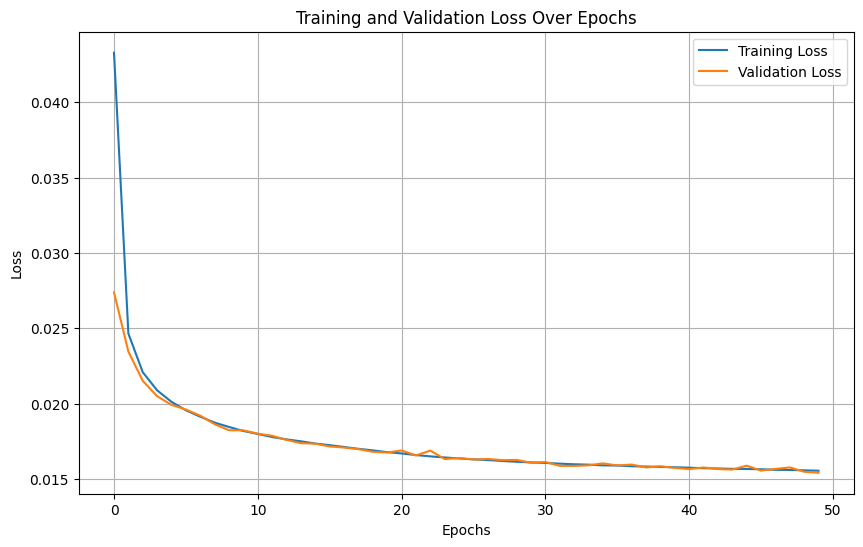

In [7]:
# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(historyCNNwReg.history['loss'], label='Training Loss')
if 'val_loss' in historyCNNwReg.history:
    plt.plot(historyCNNwReg.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [8]:
# Evaluate the autoencoder on test data
test_loss = autoencoder.evaluate(x_test, x_test, batch_size=32)
#print(f"Test Reconstruction Loss: {test_loss:.4f}")
print(f"Test Reconstruction Loss: {test_loss}")

# É approx o mesmo que a loss no conjunto de validação.

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0151
Test Reconstruction Loss: 0.015002891421318054


# Resposta exercício Lista 01:

In [9]:
# Resposta exercício Lista 01:
y_pred = autoencoder.predict(x_test)
MSE_value = np.mean((y_pred - x_test)**2)
L1_value = lambda_value * np.sum(np.abs(encoder.predict(x_test)))
print("MSE value = {}".format(MSE_value))
print("L1 value = {}".format(L1_value))
print("Percentage of L1 value with respect to total loss = {}".format(L1_value*100.0/(MSE_value + L1_value)))

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
MSE value = 0.014853843487799168
L1 value = 0.04660852625966072
Percentage of L1 value with respect to total loss = 75.8326187133789


## Análise
O termo de lambda escolhido foi capaz de ajudar no treinamento, impedindo que os pesos crescessem de maneira exagerada. Caso um valor muito mais alto ou mais baixo fosse escolhido, o termo de regularização dominaria o termo de perda ou não seria significativo, fazendo com que a rede tenha dificuldade em convergir.

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


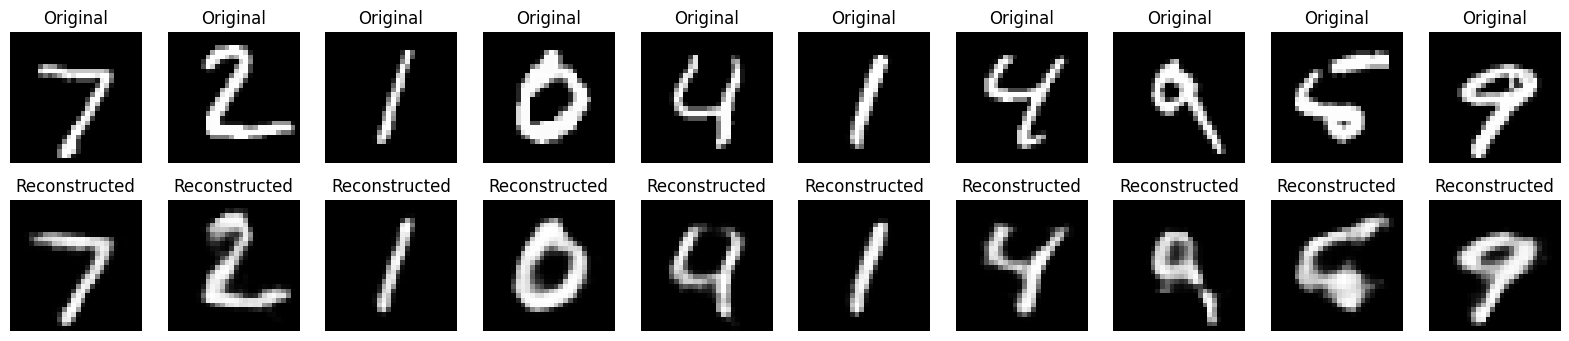

In [10]:
# Reconstruct the test data
reconstructed_images = autoencoder.predict(x_test)

# Visualize original vs reconstructed images
import matplotlib.pyplot as plt

n = 10  # Number of images to display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Original images
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28), cmap="gray")
    plt.title("Original")
    plt.axis("off")

    # Reconstructed images
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(reconstructed_images[i].reshape(28, 28), cmap="gray")
    plt.title("Reconstructed")
    plt.axis("off")
plt.show()


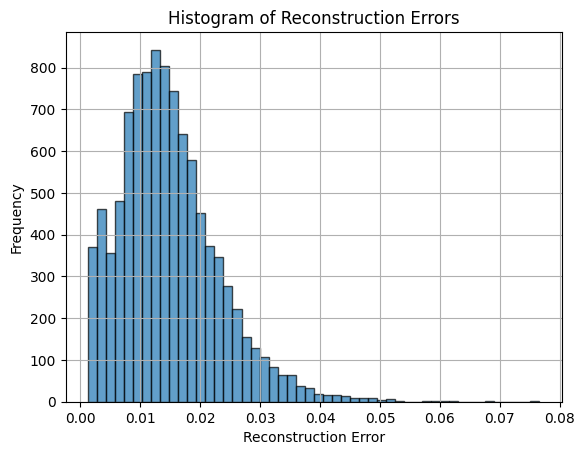

Indices of test samples with highest reconstruction errors: [1859 2436 4230 3542 1253 1758 3778 2118 4140 1782]


In [11]:
# Compute reconstruction error for each test sample
reconstruction_errors = np.mean((x_test - reconstructed_images) ** 2, axis=(1, 2, 3))

# Plot a histogram of reconstruction errors
plt.hist(reconstruction_errors, bins=50, edgecolor='k', alpha=0.7)
plt.title('Histogram of Reconstruction Errors')
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Identify the 10 samples with the highest reconstruction errors
worst_indices = np.argsort(reconstruction_errors)[-10:]
print("Indices of test samples with highest reconstruction errors:", worst_indices)


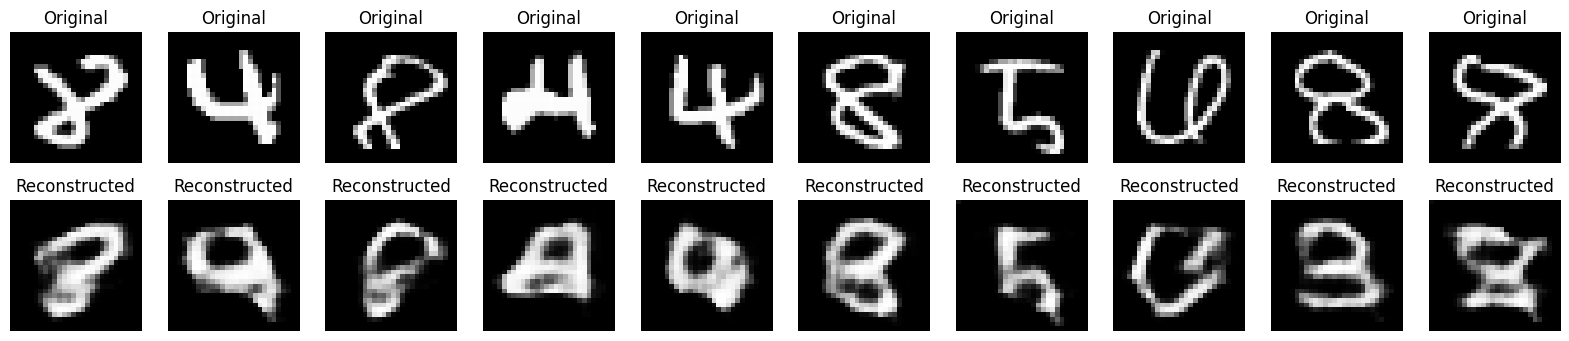

In [12]:
n = 10  # Number of samples with the highest reconstruction errors
plt.figure(figsize=(20, 4))
for i in range(n):
    # Original images
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[worst_indices[i]].reshape(28, 28), cmap="gray")
    plt.title("Original")
    plt.axis("off")

    # Reconstructed images
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(reconstructed_images[worst_indices[i]].reshape(28, 28), cmap="gray")
    plt.title("Reconstructed")
    plt.axis("off")
plt.show()


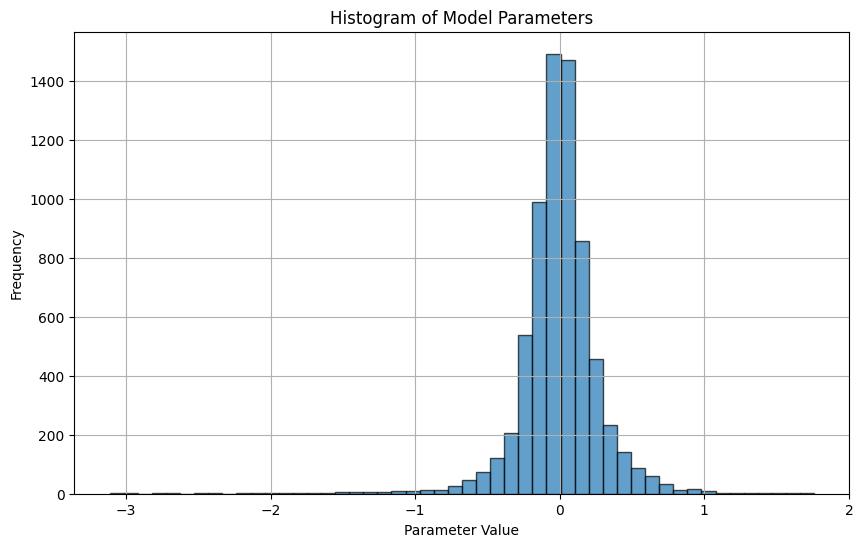

In [13]:
# Extract all trainable parameters (weights and biases)
all_weights = []
for layer in autoencoder.layers:
    if hasattr(layer, 'weights'):
        for weight in layer.weights:
            all_weights.append(weight.numpy().flatten())

# Flatten into a single array
all_weights_flat = np.concatenate(all_weights)

# Plot the histogram
plt.figure(figsize=(10, 6))
plt.hist(all_weights_flat, bins=50, edgecolor='k', alpha=0.7)
plt.title('Histogram of Model Parameters')
plt.xlabel('Parameter Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


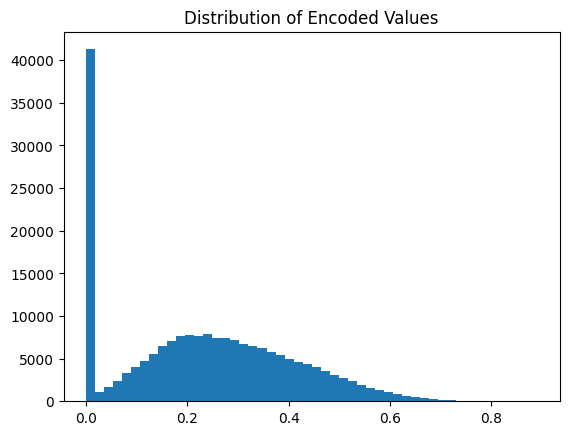

In [14]:
# Extract the encoder model
encoder_output = encoder.predict(x_test)
# encoder_output is the output of the encoder model, mapping each x_test data to their corresponding latent code representations in the 20-dimensional latent space.

# Check the distribution of the encoded values
plt.hist(encoder_output.flatten(), bins=50)
# The command encoder_output.flatten() converts the 2D array of encoded values into a 1D array, effectively mixing all the 20 coordinates for all test samples together.
# The histogram shows the distribution of all these encoded values, across all test samples and all dimensions of the latent space.
plt.title("Distribution of Encoded Values")
plt.show()

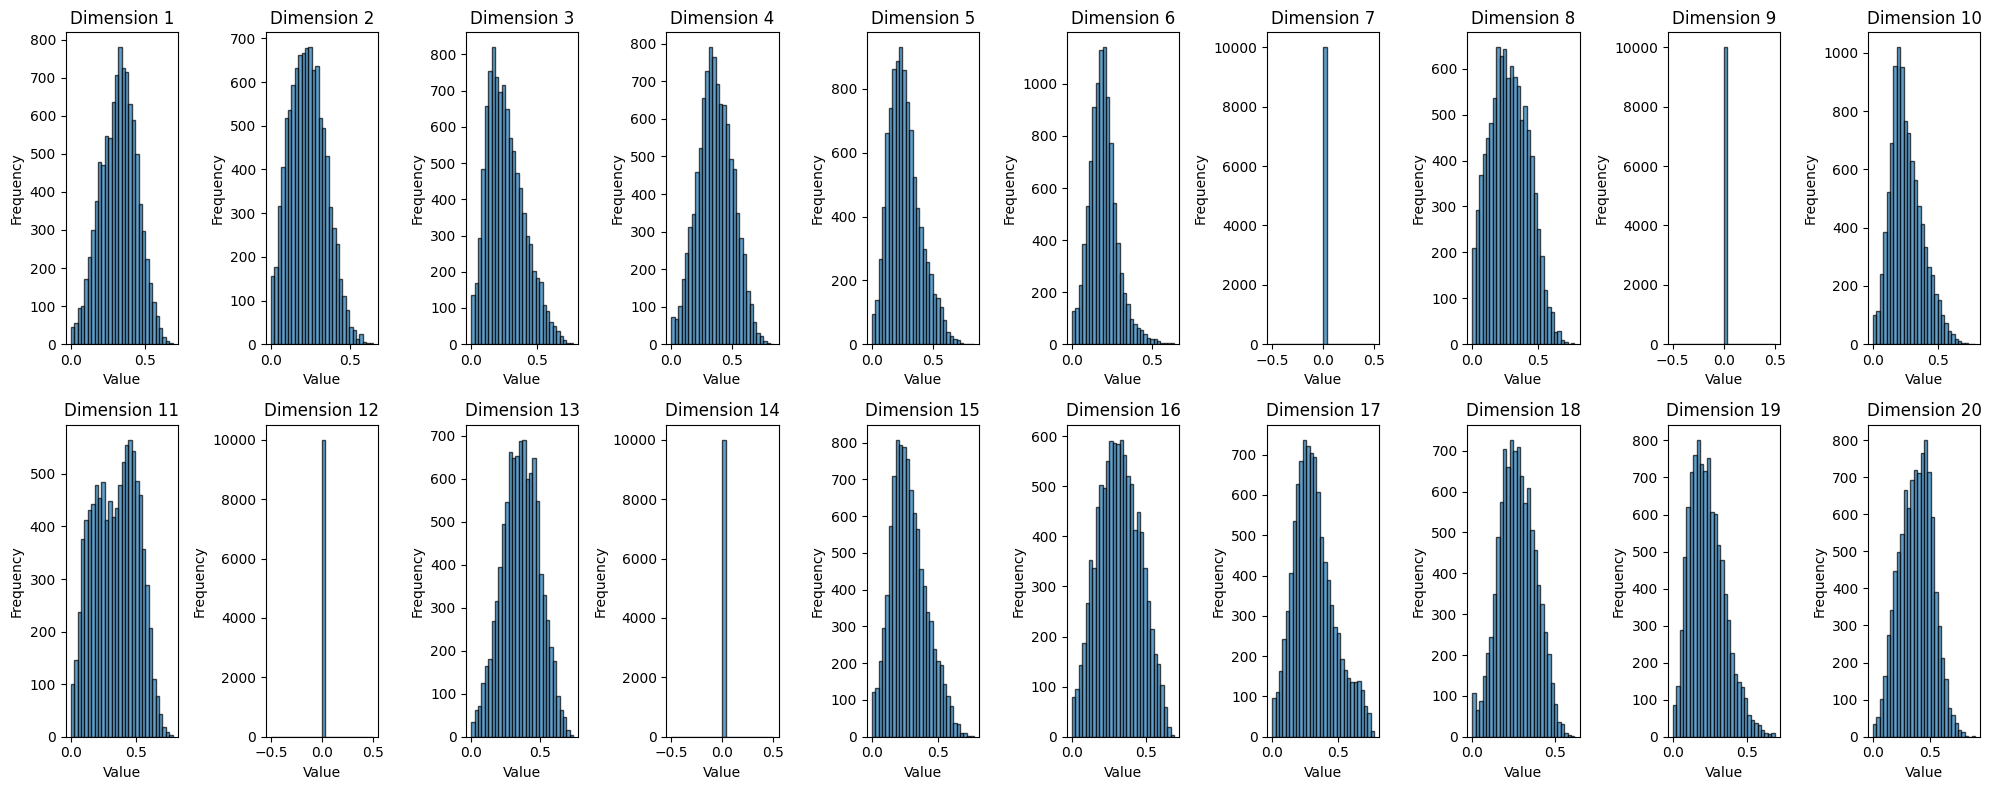

In [15]:
# Plot histograms for each of the 20 latent dimensions separately
fig, axes = plt.subplots(2, 10, figsize=(20, 8))  # 2x10 grid of histograms
axes = axes.flatten()

for i in range(20):
    axes[i].hist(encoder_output[:, i], bins=30, alpha=0.7, edgecolor='black')
    axes[i].set_title(f"Dimension {i+1}")
    axes[i].set_xlabel("Value")
    axes[i].set_ylabel("Frequency")

plt.tight_layout()
plt.show()

# We see that some coordinates were collapsed to zero.
# Which ones are zeroed and how many of them, it depends on the random initialization and other aspects of the fitting.
# Having some coordinates zeroed means that effectively we are using a code of dimension smaller than 20.

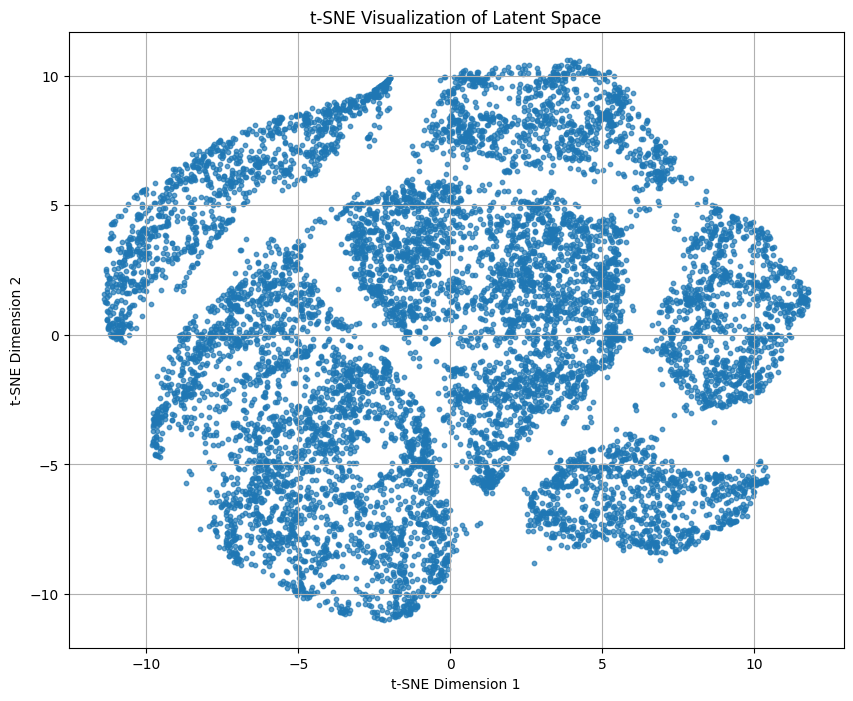

In [16]:
# We have already encoded all the test data with the previous command:
# encoder_output = encoder.predict(x_test)

# Reduce dimensionality using PCA
#pca = PCA(n_components=2)
#pca_result = pca.fit_transform(encoded_imgs)

# Reduce dimensionality using t-SNE
from sklearn.manifold import TSNE

# Reduce dimensionality using t-SNE
tsne = TSNE(n_components=2, perplexity=30, max_iter=300, random_state=42)
tsne_result = tsne.fit_transform(encoder_output)

# Plot the t-SNE results
plt.figure(figsize=(10, 8))
plt.scatter(tsne_result[:, 0], tsne_result[:, 1], alpha=0.7, s=10)
plt.title("t-SNE Visualization of Latent Space")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.grid(True)
plt.show()

/tmp/ipykernel_854477/4070988252.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cm = plt.cm.get_cmap('RdYlBu')


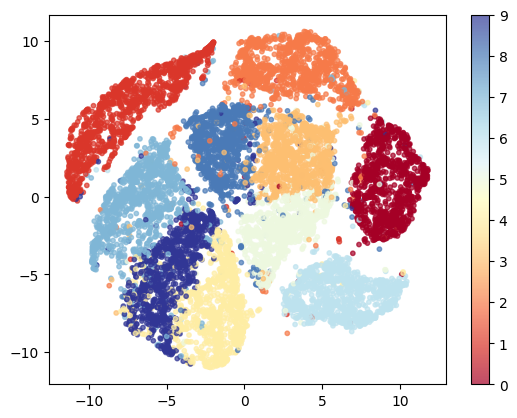

In [17]:
# Let us color each point according to its label.
# select a good color map
cm = plt.cm.get_cmap('RdYlBu')

# make the scatterplot now
plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=y_test, cmap=cm, alpha=0.7, s=10)
plt.colorbar()

# The different colors points aggregate into well seperated out clusters
# This shows that effectively only two dimensions are enough to represent most aspects of the MNIST
# Note how we can easily detected some outliers (points of a given color amid clusters of a different color)